## You've got the power

How do you determine the sample size necessary to obtain a real effect (with a desired probability)? The typical approach to this is to run a power analysis for known distributions, which analytically (i.e. using math) calculates how many participants you need to have, in order to have an 80% chance, for example, to detect an effect. One tool to accomplish that is called [G-power](http://www.gpower.hhu.de/en.html).

The problems with using G-power and similar analytical tools are that:
- you can only use them for analyses they have implemented that have a simple analytical solution (e.g., t-tests, ANOVA). They do not offer power analyses for mixed-effects regressions and many other tools that you have learned in the class.
- they calculate power only as a function of "number of participants" - they do not take into account the fact that increasing the number of observations per participant can also increase power, by decreasing variability in individual estimates

The solution to these problems is to do power analyses by simulation. The idea is actually quite simple - you repeatedly simulate artificial data by choosing plausible parameters given the existing literature or expected effect sizes and then you run the analysis of your choice on the simulated data. The proportion of simulations in which you find a statistically significant result is the power of your study, or the probability with which you can expect to find a real effect of that size in your sample.



## Basic algorithm

Simulation power analyses follow these steps, on which we'll expand in the subsequent sections:
1. Determine sources of variance - between subject variability, trial-by-trial variability, etc
2. Write a data simualtion function that has:
    - input: are parameters that control sample size, number of trials, means and variances of conditions, etc
    - procedure: simulate observations given these parameters
    - output: simulated dataset
3. Write an analysis function that has:
    - input: simulated dataset
    - procedure: run analysis and extract statistical significance
    - output: statistical significance value (p-value, $\delta$ AIC, BIC, etc)
4. Write a loop that:
    - repeatedly runs the prior two functions for each different sample size and numbers of trials and extracts the proportion of simulations for each in which the analysis is significant

### Determine sources of variance

The outcome of any statistical analysis basically depends on how much your observations vary as you sample them. Variance comes from many sources - there are individual differences, noisy sampling, trial-by-trial variability, etc. Which of these variance sources you need to specify depends on the domain and the analysis you want to run.

Let's say you want to determine whether men are on average higher than women. There is a "true" underlying difference in the population, such that if you measure the heights of all men and all women you would get the following population parameters.:

$$\mu_{m} = 177 cm$$

$$\mu_w = 163 cm$$

However, since each man and each woman vary in their heights, if you sample 10 of each, you would get sample statistics that are similar, but not identical to the population parameters. It is even possible that you would, by chance, with such a small sample get a group of women that are on average higher than men. 

Therefore, in order to run a power analysis for a t-test comparing the height of men and women, you need to specify how much you expect the individual people to vary in height. Since in adulthood height is mostly constant from day to day, you don't have to wory in this case for repeated measurements and their variability and you can just run a simple t-test. Let's do it the algorithm specified above. 

Height is normally distributed with the above means and standard deviations of:

$$\sigma_m = 7cm$$

$$\sigma_w = 6.3cm$$

We can also use the following notation, which means that height is distributed normally with the given means and variance:

$$Height_m \sim \mathcal{N}(\mu_m,\,\sigma_m^{2})$$

$$Height_w \sim \mathcal{N}(\mu_w,\,\sigma_w^{2})$$

In [16]:
# a function for simulating data for two groups. Sample size is the number of people in each group
simulate_data <- function(sample_size, group1_mu, group1_sd, group2_mu, group2_sd) {
    # draw observation from a normal distribution
    obs_group1 <- rnorm(sample_size, group1_mu, group1_sd)
    obs_group2 <- rnorm(sample_size, group2_mu, group2_sd)
    return(data.frame(group1=obs_group1, group2=obs_group2))
}

# a function for running a t-test and extracting p-value
run_analysis <- function(data) {
    fit <- t.test(data$group1, data$group2)
    return(fit$p.value)
}

With the first function we can simulate heights for 5 men and women:

In [12]:
set.seed(18946)
heights = simulate_data(5, 177, 7, 163, 6.3)
print(heights)

    group1   group2
1 168.6179 149.5882
2 179.6907 163.4565
3 180.3962 168.9947
4 183.3329 151.7975
5 177.5582 164.0255


With the second function we can run an independent sample t.test and extract the p.value:

In [13]:
run_analysis(heights)

[1] 0.004895769

Now, this particular sample had significantly different heights. However, we may have just been lucky. If we repeat this process many times for this particular sample size, what proportion of cases will we find a significant difference? Let's put both previous functions together and repeat them 1000 times:

In [30]:
# a function for repeatedly running the t-test on multiple samples drawn with the same parameters
repeat_analysis <- function(n_simulations, alpha, sample_size, group1_mu, group1_sd, group2_mu, group2_sd) {
    p.values <- c() # empty vector to store p.values from each simulation
    # loop for repeating the simulation
    for (i in 1:n_simulations) {
        data <- simulate_data(sample_size, group1_mu, group1_sd, group2_mu, group2_sd)
        p.value <- run_analysis(data)
        p.values <- c(p.values, p.value) # add the current p.value to the vector
    }
    
    # calculate how many of the simulations had significant results
    power <- mean(p.values <= alpha)
    return(list(power = power, p.values = p.values))
}


For a 1000 simulations of 5 participants per group and a alpha significance level of 0.05, we have a power of:

In [31]:
set.seed(18546)
results = repeat_analysis(1000, 0.05, 5, 177, 7, 163, 6.3)
results$power

[1] 0.816

This means that there is an 81.6% probability that a we can detect a significant difference (at p < 0.05) in heights between men and women if we measure 5 of each. If we measure 10 people per group instead, we get a much higher power:

In [32]:
set.seed(18546)
results = repeat_analysis(1000, 0.05, 10, 177, 7, 163, 6.3)
results$power

[1] 0.988

If we become more conservative with our statistical threshold, power decreases:

In [33]:
set.seed(18546)
results = repeat_analysis(1000, 0.001, 10, 177, 7, 163, 6.3)
results$power

[1] 0.756

Just to make it clearer, we can visualize the distribution of p.values obtained from each simulation:

[1] 0.798

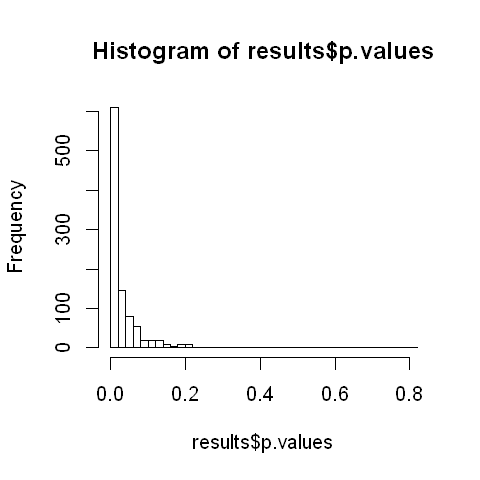

In [50]:
options(repr.plot.width=4, repr.plot.height=4)
results = repeat_analysis(1000, 0.05, 5, 177, 7, 163, 6.3)
results$power
hist(results$p.values, breaks = 50)

Now, for the inverse question, how many people do we need to be 95% certain that we will detect a significant difference in heights between men and women? You could manually play arround with the function's parameters, until you obtain a desired level of power, but we can instead simulated data for different sample sizes automatically and choose the one that gives us the desired level. We will use the `tidyverse` package to create a dataframe with parameters, then simulate data for each row of the dataframe, store the results in a column, then run the analysis on that column and store the resulting p.value. Check these two tutorials for more details on how to do that: [Link 1](https://github.com/CoAxLab/DataSciencePsychNeuro_CMU85732/blob/master/Tutorials/Tutorial2_DataProcessingWithRAndTidyverse.ipynb) and [Link 2](https://github.com/CoAxLab/DataSciencePsychNeuro_CMU85732/blob/master/Tutorials/Tutorial8_FittingIndVsGroup.ipynb)

In [87]:
library(tidyverse)
# first, create a data.frame to store the results
dat <- expand.grid(sample_size = 2:20, alpha = c(0.05,0.01,0.001))
dat$id <- 1:nrow(dat)

# then use tidyverse functions to run the analsyis for each sample size
results <- dat  %>% 
    nest(-id, .key = 'pars')  %>% 
    mutate(power = map(pars, ~ repeat_analysis(1000, .$alpha, .$sample_size, 177, 7, 163, 6.3)$power))  %>% 
    unnest(pars, power)

We can plot the power level for the different sample sizes and alpha levels:

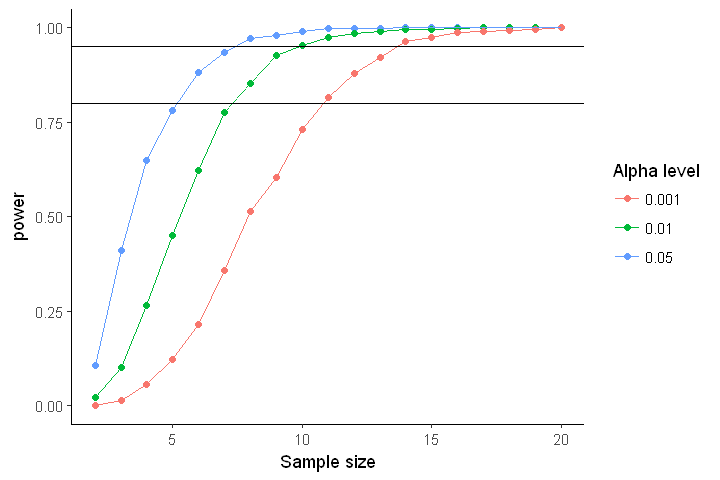

In [94]:
options(repr.plot.width=6)
ggplot(results, aes(sample_size, power, color=as.factor(alpha), group=alpha)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 0.8) +
    geom_hline(yintercept = 0.95) +
    scale_color_discrete('Alpha level') +
    scale_x_continuous('Sample size') +
    theme_classic()

You can see, that for a power of 95% you need 14 people per group to detect difference in height at the 0.001 level.

### Extending to more complicated analyses: Example with mixed-models

The basic procedure outlined above and the functions presented can be extended to any type of analysis in which there is a discrete threshold for making significance decisions. The only thing that has to be changed is the generation of the data and the analysis function. In generating the data, the most complicated thing is specifying the variance structure. 

Let's take for example a mixed-effects regression of reaction times in a priming lexical decision experiment. We are interested in whether people make lexical decision ('Is this string a word or not?') faster after semantically congruent rather than semantically incongruent items. How do we generate data for this? Typical psycholinguistic experiments use repeated measures designs where each participant performs many trials in each condition. The reaction time to any trial is determined by:
- mean of each condition (expected population priming effect)
- individual differences in:
    - overall speed (different intercepts for each subject)
    - difference between conditions (some people might be more strongly affected by the manipulation than others)
- trial-by-trial variation


So our mixed effects model and data structure would be as follows:

$$RTs = \beta_{subject\_intercept} + \beta_{subject\_slope} * condition + \epsilon_{trial}$$

$$\beta_{subject\_intercept} = \beta_{overall\_intercept} + \epsilon_{intercept}$$

$$\beta_{subject\_slope} = \beta_{mean\_difference} + \epsilon_{slope}$$

$$\epsilon_{trial} \sim \mathcal{N}(0, \sigma_{trial}^2)$$

$$\epsilon_{intercept} \sim \mathcal{N}(0, \sigma_{intercept}^2)$$

$$\epsilon_{slope} \sim \mathcal{N}(0, \sigma_{slope}^2)$$

In our simulation, then, we need to specify 5 parameters for the data generation:
- $\beta_{overall\_intercept}$ (Average RTs for congruent primes)
- $\beta_{mean\_difference}$ (Average RT difference between congruent and incongruent primes)
- $\sigma_{trial}$ (The standard deviation of RTs on each trial, if one participant responds to the same item)
- $\sigma_{intercept}$ (How much individual subjects vary in their overall speed)
- $\sigma_{mean_difference}$ (How much individual subjects vary in how strongly they are affected by priming)

Let's pick some plausible parameters based on prior literature and educated guessing:

$$\beta_{overall\_intercept} = 700 ms.$$

$$\beta_{mean\_difference} = 50 ms.$$

$$\sigma_{trial} = 200 ms.$$

$$\sigma_{intercept} = 100 ms.$$ 

$$\sigma_{mean_difference} = 50 ms.$$

How many subjects and trials per subject do we need to achieve 80% power? Let's adapt our functions

In [5]:
# a function for simulating data for mixed-model.
simulate_data <- function(n_subjects, n_trials, intercept, slope, intercept_sd, slope_sd, trial_sd) {
    # draw observation from a normal distribution
    subject_intercepts <- rnorm(n_subjects, intercept, intercept_sd)
    subject_slopes <- rnorm(n_subjects, slope, slope_sd)
    dat <- data.frame(subject = 1:n_subjects, intercept = subject_intercepts, slope=subject_slopes)
    # generate trials for each subject
    dat <- dat  %>% 
        nest(-subject, .key = pars)  %>% 
        mutate(congruent = map(pars, ~rnorm(n_trials, intercept, trial_sd)),
               incongruent = map(pars, ~rnorm(n_trials, intercept+slope, trial_sd)))  %>% 
        unnest(congruent,incongruent, .drop = FALSE)  %>% 
        unnest(pars)  %>% 
        gather(prime, rt, congruent, incongruent)
    return(dat)
}


# a function for running a mixed-model and extract p-value
run_analysis <- function(data) {
    # fit null and alternative model
    ml0 <- lmer(rt ~ 1 + (prime||subject), data=data, REML=FALSE, control=lmerControl(calc.derivs = FALSE))
    ml1 <- lmer(rt ~ prime + (prime||subject), data=data, REML=FALSE, control=lmerControl(calc.derivs = FALSE))
    # run a likelihood ratio test and extract p.value. You can replace with change in AIC or BIC
    llrt <- anova(ml0, ml1)
    statistic <- llrt$`Pr(>Chisq)`[2]
    return(statistic)
}

Before we run the full analysis, just for demonstration, here is simulated data for some subjects:

In [6]:
set.seed(8923332)
dat <- simulate_data(10, 10, 700, 50, 100,50,200)
head(dat, n=20)

subject,intercept,slope,prime,rt
1,653.4452,9.970433,congruent,556.9333
1,653.4452,9.970433,congruent,834.7421
1,653.4452,9.970433,congruent,550.1699
1,653.4452,9.970433,congruent,770.3064
1,653.4452,9.970433,congruent,511.8577
1,653.4452,9.970433,congruent,841.3645
1,653.4452,9.970433,congruent,576.9677
1,653.4452,9.970433,congruent,910.4586
1,653.4452,9.970433,congruent,803.5632
1,653.4452,9.970433,congruent,565.9185


And here's the output of the model concerning the effect of priming:

In [26]:
run_analysis(dat)

[1] 0.04223599

Let's run the simulation for various number of subjects and trials. This takes a long time, btw.

In [27]:
# a function for repeatedly running the analysis on multiple samples drawn with the same parameters
repeat_analysis <- function(n_simulations, alpha, n_subjects, n_trials, intercept, slope, intercept_sd, slope_sd, trial_sd) {
    p.values <- c() # empty vector to store p.values from each simulation
    # loop for repeating the simulation
    for (i in 1:n_simulations) {
        data <- simulate_data(n_subjects, n_trials, intercept, slope, intercept_sd, slope_sd, trial_sd)
        p.value <- run_analysis(data)
        p.values <- c(p.values, p.value) # add the current p.value to the vector
    }
    
    # calculate how many of the simulations had significant results
    power <- mean(p.values <= alpha)
    return(list(power = power, p.values = p.values))
}

In [ ]:
dat <- expand.grid(n_subjects = c(10,20,30,40), n_trials = c(10,20,30,40))
dat$id <- 1:nrow(dat)

# then use tidyverse functions to run the analsyis for each sample size (takes ~30-60 minutes)
results <- dat  %>% 
    nest(-id, .key = 'pars')  %>% 
    mutate(power = map(pars, ~ repeat_analysis(1000, 0.05, .$n_subjects, .$n_trials, 700, 50, 100,50,200)$power))  %>% 
    unnest(pars, power)

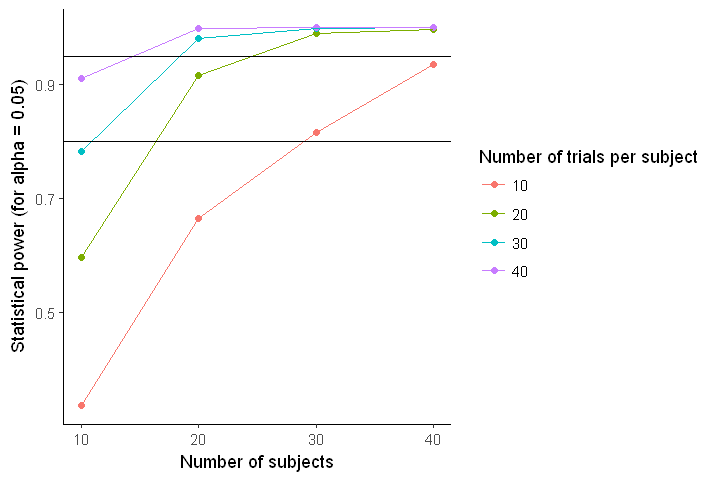

In [36]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(results, aes(n_subjects, power, color=as.factor(n_trials), group=n_trials)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 0.8) +
    geom_hline(yintercept = 0.95) +
    scale_color_discrete('Number of trials per subject') +
    scale_x_continuous('Number of subjects') +
    scale_y_continuous('Statistical power (for alpha = 0.05)') +
    theme_classic()

So, you can see that power, at least given these variability parameters, is a function of both the number of subjects and the number of trials per subject. In this case 10 subjects with 30 trials per subject or 30 subjects with 10 trials per subject both results ~80% power. So, if subject recruitment is difficult or expensive, you can test each subject for longer instead. 

#### What is more important, # subjects or # trials?

This depends on the relative sizes of the $\sigma_{trial}$ and $\sigma_{slope}$, i.e., how much observations vary from trial to trial, and how much the true effect varies from subject to subject. If $sigma_{slope}$ is relatively large, adding more subjects will be more important for estimating the population level difference, because it will improve its estimation more than adding more trials. If however people are more homogenous, and respond similarly to the manipulation, then adding more trials would be more efficient. To test this out, you can run the above simulation for different values of $\sigma_{trial}$ and $\sigma_{slope}$, and see it for yourself.